In [17]:
%pip install tensorflow tensorflow-macos tensorflow-metal opencv-python pandas matplotlib scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


No GPU detected. Running on CPU.
Loading train data (3530 images)...


100%|██████████| 3530/3530 [00:06<00:00, 506.62it/s]


Loading valid data (801 images)...


100%|██████████| 801/801 [00:02<00:00, 387.06it/s]


Loading test data (638 images)...


100%|██████████| 638/638 [00:01<00:00, 430.65it/s]


EXPERIMENT 1: K-FOLD CROSS VALIDATION (Training Data Only)
Using limited dataset: 500 samples

Fold 1/5
  Result: IoU=0.4407, F1=0.7423

Fold 2/5
  Result: IoU=0.4301, F1=0.7381

Fold 3/5
  Result: IoU=0.4098, F1=0.7446

Fold 4/5
  Result: IoU=0.3126, F1=0.6272

Fold 5/5
  Result: IoU=0.2577, F1=0.6010

Saved K-Fold results -> maskrcnn_kfold_results.csv

EXPERIMENT 2: HYPERPARAMETER TUNING (Train/Validation Data)

Expt 1/4 -> LR: 0.001, Batch: 16, Opt: adam
  Score: IoU=0.4993, F1=0.8446

Expt 2/4 -> LR: 0.001, Batch: 32, Opt: adam
  Score: IoU=0.4902, F1=0.8414

Expt 3/4 -> LR: 0.0005, Batch: 16, Opt: adam
  Score: IoU=0.4812, F1=0.8302

Expt 4/4 -> LR: 0.0005, Batch: 32, Opt: adam
  Score: IoU=0.4496, F1=0.8140

Best Configuration:
learning_rate       0.001
batch_size             16
optimizer            adam
iou              0.499267
f1_score         0.844558
val_loss         0.191839
Name: 0, dtype: object

FINAL TRAINING & EVALUATION
Training Final Model on 4331 samples...
Epoch 1/

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



******************************
FINAL TEST RESULTS
******************************
Iou: 0.5654
Precision: 0.8924
Recall: 0.8847
Accuracy: 0.9537
F1_score: 0.8885


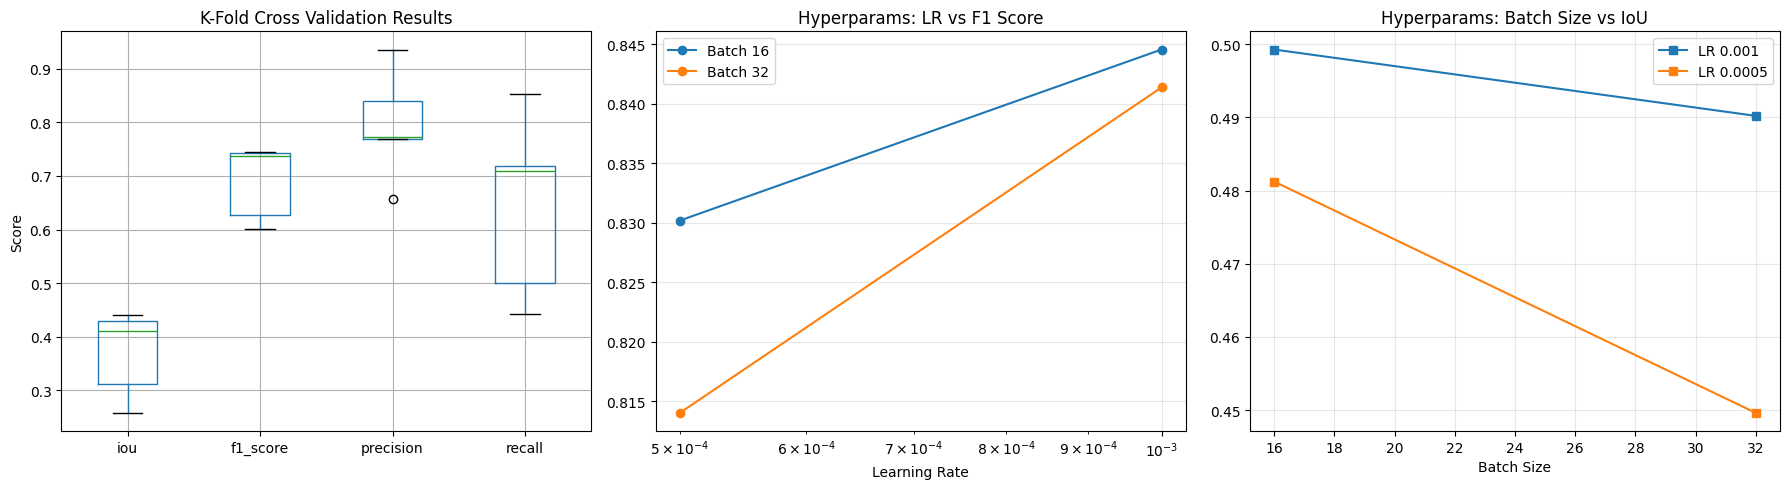

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm

# --- 1. M1 Mac Configuration & Setup ---
try:
    # Check for GPU (Metal)
    devices = tf.config.list_physical_devices('GPU')
    if devices:
        print(f"GPU Detected: {devices}")
        for device in devices:
            tf.config.experimental.set_memory_growth(device, True)
    else:
        print("No GPU detected. Running on CPU.")
except Exception as e:
    print(f"Error configuring GPU: {e}")

# Set seeds for reproducibility (Matching UNET)
tf.random.set_seed(42)
np.random.seed(42)

# --- 2. Data Loading (Referencing UNET Logic) ---
def load_yolo_annotations(img_path, img_shape):
    """Convert YOLO format to segmentation mask (Same as UNET)"""
    annotation_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')
    
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    
    if os.path.exists(annotation_path):
        try:
            with open(annotation_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                data = line.strip().split()
                if len(data) >= 5:
                    # YOLO format: class x_center y_center width height (normalized)
                    x_center, y_center, width, height = map(float, data[1:5])
                    
                    h, w = img_shape[:2]
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    x1 = max(0, int(x_center - width/2))
                    y1 = max(0, int(y_center - height/2))
                    x2 = min(w, int(x_center + width/2))
                    y2 = min(h, int(y_center + height/2))
                    
                    if x2 > x1 and y2 > y1:
                        mask[y1:y2, x1:x2] = 1
        except Exception as e:
            print(f"Error processing annotation {annotation_path}: {e}")
                
    return mask

def load_complete_dataset(data_path, img_size=(128, 128)): # Reduced size for MaskRCNN speed
    """Load train, validation, and test datasets"""
    
    def load_split(split_name):
        # Handle case sensitivity in folder names (Train/train)
        possible_paths = [os.path.join(data_path, split_name), os.path.join(data_path, split_name.capitalize())]
        split_path = next((p for p in possible_paths if os.path.exists(p)), None)
        
        if not split_path:
            print(f"Warning: Could not find directory for {split_name}")
            return np.array([]), np.array([])

        images_path = os.path.join(split_path, 'images')
        
        images = []
        masks = []
        
        if not os.path.exists(images_path):
            print(f"Warning: {images_path} does not exist")
            return np.array([]), np.array([])
            
        file_list = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Loading {split_name} data ({len(file_list)} images)...")
        for filename in tqdm(file_list):
            img_path = os.path.join(images_path, filename)
            
            # Load and preprocess image
            img = cv2.imread(img_path)
            if img is None: continue
            
            original_shape = img.shape
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
            
            # Load mask using YOLO parser
            mask = load_yolo_annotations(img_path, original_shape)
            mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)
            
            images.append(img)
            masks.append(mask)
            
        return np.array(images), np.array(masks)

    train_X, train_y = load_split('train')
    val_X, val_y = load_split('valid')
    test_X, test_y = load_split('test')
    
    return (train_X, train_y), (val_X, val_y), (test_X, test_y)

# --- 3. Model Definition (TinyMaskRCNN) - Updated for M1 ---
class TinyMaskRCNN:
    """
    A simplified Mask R-CNN style architecture compatible with the 
    training loops used in the UNET file.
    """
    def __init__(self, input_shape=(128, 128, 3), learning_rate=0.001, optimizer_name='adam'):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name
        self.model = self.build_model()
        
    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        
        # Encoder (Backbone)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2))(x)
        
        # RPN-like Branch (Simplified)
        rpn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        
        # Decoder (Mask Head)
        x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(rpn)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
        
        # Output
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
        
        model = keras.Model(inputs, outputs, name="TinyMaskRCNN")
        
        # --- M1/M2 OPTIMIZER FIX ---
        # We use .legacy.Adam because the newer v2.11+ optimizer is slow on Apple Silicon
        if self.optimizer_name == 'adam':
            try:
                opt = keras.optimizers.legacy.Adam(learning_rate=self.learning_rate)
            except AttributeError:
                # Fallback for systems that don't have the legacy path (non-Macs)
                opt = keras.optimizers.Adam(learning_rate=self.learning_rate)
                
        elif self.optimizer_name == 'rmsprop':
            try:
                opt = keras.optimizers.legacy.RMSprop(learning_rate=self.learning_rate)
            except AttributeError:
                opt = keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        else:
            # Default to legacy Adam
            try:
                opt = keras.optimizers.legacy.Adam(learning_rate=self.learning_rate)
            except AttributeError:
                opt = keras.optimizers.Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
        
    def predict(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)
        
    def save(self, filepath):
        self.model.save(filepath)

# --- 4. Metrics Helper Functions (Copied from UNET) ---
def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    y_true_bin = (y_true > 0.5).astype(np.float32)
    
    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin) - intersection
    return intersection / (union + 1e-7)

def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.float32)
    y_true_bin = (y_true > 0.5).astype(np.float32)
    
    tp = np.sum(y_true_bin * y_pred_bin)
    fp = np.sum((1 - y_true_bin) * y_pred_bin)
    fn = np.sum(y_true_bin * (1 - y_pred_bin))
    
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return precision, recall, f1

# --- 5. Experiment 1: K-Fold Cross Validation ---
def experiment_kfold(X_train, y_train, n_splits=5, max_samples=500):
    print("=" * 70)
    print("EXPERIMENT 1: K-FOLD CROSS VALIDATION (Training Data Only)")
    print("=" * 70)
    
    # Limit data if requested (to speed up testing on Mac)
    if max_samples and len(X_train) > max_samples:
        X_t = X_train[:max_samples]
        y_t = y_train[:max_samples]
        print(f"Using limited dataset: {len(X_t)} samples")
    else:
        X_t, y_t = X_train, y_train

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_t)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        X_fold_train, X_fold_val = X_t[train_idx], X_t[val_idx]
        y_fold_train, y_fold_val = y_t[train_idx], y_t[val_idx]
        
        # Initialize fresh model
        model_wrapper = TinyMaskRCNN(input_shape=X_train.shape[1:])
        
        # Train
        model_wrapper.fit(X_fold_train, y_fold_train, 
                          validation_data=(X_fold_val, y_fold_val),
                          epochs=5, batch_size=16, verbose=0)
        
        # Evaluate
        preds = model_wrapper.predict(X_fold_val, verbose=0)
        
        iou = np.mean([calculate_iou(y_fold_val[i], preds[i]) for i in range(len(y_fold_val))])
        prec, rec, f1 = calculate_metrics(y_fold_val, preds)
        acc = model_wrapper.model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
        
        results = {
            'fold': fold + 1,
            'iou': iou,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'val_accuracy': acc
        }
        fold_results.append(results)
        print(f"  Result: IoU={iou:.4f}, F1={f1:.4f}")

    df = pd.DataFrame(fold_results)
    df.to_csv("maskrcnn_kfold_results.csv", index=False)
    print("\nSaved K-Fold results -> maskrcnn_kfold_results.csv")
    return df

# --- 6. Experiment 2: Hyperparameter Tuning ---
def run_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    print("\n" + "=" * 70)
    print("EXPERIMENT 2: HYPERPARAMETER TUNING (Train/Validation Data)")
    print("=" * 70)
    
    # Define Hyperparameters (Same as UNET)
    hyperparameters = {
        'learning_rate': [0.001, 0.0005],
        'batch_size': [16, 32],
        'optimizer': ['adam'] # Reduced for speed, add 'rmsprop' if needed
    }
    
    results = []
    total_exps = len(hyperparameters['learning_rate']) * len(hyperparameters['batch_size']) * len(hyperparameters['optimizer'])
    curr_exp = 1
    
    for lr in hyperparameters['learning_rate']:
        for bs in hyperparameters['batch_size']:
            for opt_name in hyperparameters['optimizer']:
                print(f"\nExpt {curr_exp}/{total_exps} -> LR: {lr}, Batch: {bs}, Opt: {opt_name}")
                
                model_wrapper = TinyMaskRCNN(input_shape=X_train.shape[1:], learning_rate=lr, optimizer_name=opt_name)
                
                # Train
                history = model_wrapper.fit(X_train, y_train, 
                                          validation_data=(X_val, y_val),
                                          epochs=5, batch_size=bs, verbose=0)
                
                # Metrics
                preds = model_wrapper.predict(X_val, verbose=0)
                iou = np.mean([calculate_iou(y_val[i], preds[i]) for i in range(len(y_val))])
                _, _, f1 = calculate_metrics(y_val, preds)
                
                results.append({
                    'learning_rate': lr,
                    'batch_size': bs,
                    'optimizer': opt_name,
                    'iou': iou,
                    'f1_score': f1,
                    'val_loss': history.history['val_loss'][-1]
                })
                print(f"  Score: IoU={iou:.4f}, F1={f1:.4f}")
                curr_exp += 1
                
    df = pd.DataFrame(results)
    df.to_csv("maskrcnn_tuning_results.csv", index=False)
    
    # Get best config based on IoU
    best_config = df.loc[df['iou'].idxmax()]
    print("\nBest Configuration:")
    print(best_config)
    
    return df, best_config

# --- 7. Final Evaluation & Visualization ---
def final_evaluation(best_config, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n" + "=" * 70)
    print("FINAL TRAINING & EVALUATION")
    print("=" * 70)
    
    # Combine Train + Val
    X_full = np.concatenate([X_train, X_val])
    y_full = np.concatenate([y_train, y_val])
    
    print(f"Training Final Model on {len(X_full)} samples...")
    model_wrapper = TinyMaskRCNN(
        input_shape=X_full.shape[1:], 
        learning_rate=best_config['learning_rate'],
        optimizer_name=best_config['optimizer']
    )
    
    history = model_wrapper.fit(X_full, y_full, epochs=15, 
                                batch_size=int(best_config['batch_size']), verbose=1)
    
    # Test Evaluation
    print("\nRunning Test Set Evaluation...")
    preds = model_wrapper.predict(X_test, verbose=0)
    
    iou = np.mean([calculate_iou(y_test[i], preds[i]) for i in range(len(y_test))])
    prec, rec, f1 = calculate_metrics(y_test, preds)
    acc = history.history['accuracy'][-1] # Train accuracy as proxy or calc test accuracy
    
    results_dict = {
        "iou": float(iou),
        "precision": float(prec),
        "recall": float(rec),
        "accuracy": float(acc),
        "f1_score": float(f1)
    }
    
    # Save to JSON (Matching UNET format)
    with open("final_maskrcnn_test_results.json", "w") as f:
        json.dump(results_dict, f, indent=4)
        
    model_wrapper.save("final_maskrcnn_model.h5")
    
    print("\n" + "*" * 30)
    print("FINAL TEST RESULTS")
    print("*" * 30)
    for k, v in results_dict.items():
        print(f"{k.capitalize()}: {v:.4f}")
        
    return results_dict

def plot_results(kfold_df, tuning_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. K-Fold Boxplot
    metrics = ['iou', 'f1_score', 'precision', 'recall']
    kfold_df[metrics].boxplot(ax=axes[0])
    axes[0].set_title('K-Fold Cross Validation Results')
    axes[0].set_ylabel('Score')
    
    # 2. Hyperparam: LR vs F1
    for bs in tuning_df['batch_size'].unique():
        subset = tuning_df[tuning_df['batch_size'] == bs]
        axes[1].plot(subset['learning_rate'], subset['f1_score'], marker='o', label=f'Batch {bs}')
    axes[1].set_title('Hyperparams: LR vs F1 Score')
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Hyperparam: Batch Size vs IoU
    for lr in tuning_df['learning_rate'].unique():
        subset = tuning_df[tuning_df['learning_rate'] == lr]
        axes[2].plot(subset['batch_size'], subset['iou'], marker='s', label=f'LR {lr}')
    axes[2].set_title('Hyperparams: Batch Size vs IoU')
    axes[2].set_xlabel('Batch Size')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- 8. Main Execution Block ---
if __name__ == "__main__":
    # Define Path
    # Updated to match the path found in your snippets
    DATA_PATH = "/Users/v/Desktop/Fall 2025 Syllabus/CSCI 331 Project/CSCI-331-04-Group-10/data/car"
    
    if os.path.exists(DATA_PATH):
        # 1. Load Data
        (train_X, train_y), (val_X, val_y), (test_X, test_y) = load_complete_dataset(DATA_PATH)
        
        if len(train_X) > 0:
            # 2. Run Experiments
            kfold_df = experiment_kfold(train_X, train_y, n_splits=5)
            tuning_df, best_config = run_hyperparameter_tuning(train_X, train_y, val_X, val_y)
            
            # 3. Final Eval
            final_evaluation(best_config, train_X, train_y, val_X, val_y, test_X, test_y)
            
            # 4. Plot
            plot_results(kfold_df, tuning_df)
        else:
            print("Error: No training data loaded. Check paths.")
    else:
        print(f"Error: Data path not found: {DATA_PATH}")